In [ ]:
!sudo apt install imagemagick
!mkdir -o data/coco/
!curl http://images.cocodataset.org/annotations/annotations_trainval2014.zip -o data/coco/raw.zip
!unzip data/coco/raw.zip
!mv data/coco/annotations/captions_train2014.json data/coco/
!rm -rf data/coco/annotations
!rm data/coco/raw.zip
!curl http://images.cocodataset.org/zips/train2014.zip -o data/coco/images.zip
!unzip data/coco/images.zip
!rm data/coco/images.zip
!mogrify -resize 224x data/coco/images/*.jpg

In [ ]:
!pip install pandas
!pip install pillow
!pip install torch
!pip install superduperdb

In [16]:
import json

with open('data/coco/captions_train2014.json') as f:
    raw = json.load(f)
    
raw['images'] = {x['id']: x for x in raw['images']}

for im in raw['images']:
    raw['images'][im]['captions'] = []
    
for a in raw['annotations']:
    raw['images'][a['image_id']]['captions'].append(a['caption'])

raw = list(raw['images'].values())

for i, im in enumerate(raw):
    im['img'] = {
        '_content': {'url': f'file://data/coco/images/{im["file_name"]}', 'type': 'image'}
    }
    raw[i] = {'captions': im['captions'], 'img': im['img']}

with open('data/coco/data.json', 'w') as f:
    json.dump(raw, f)

In [10]:
import json
import sys

sys.path.append('../../')

from superduperdb.client import the_client
from IPython.display import display, clear_output
import torch

docs = the_client.coco_example.documents

In [17]:
with open('data/coco/data.json') as f:
    data = json.load(f)
    
data[:5]

[{'captions': ['A restaurant has modern wooden tables and chairs.',
   'A long restaurant table with rattan rounded back chairs.',
   'a long table with a plant on top of it surrounded with wooden chairs ',
   'A long table with a flower arrangement in the middle for meetings',
   'A table is adorned with wooden chairs with blue accents.'],
  'img': {'_content': {'url': 'file://data/coco/images/COCO_train2014_000000057870.jpg',
    'type': 'image'}}},
 {'captions': ['A man preparing desserts in a kitchen covered in frosting.',
   'A chef is preparing and decorating many small pastries.',
   'A baker prepares various types of baked goods.',
   'a close up of a person grabbing a pastry in a container',
   'Close up of a hand touching various pastries.'],
  'img': {'_content': {'url': 'file://data/coco/images/COCO_train2014_000000384029.jpg',
    'type': 'image'}}},
 {'captions': ['a big red telephone booth that a man is standing in',
   'a person standing inside of a phone booth ',
   't

In [ ]:
from examples.types import FloatTensor, Image

docs.create_type('float_tensor', FloatTensor())
docs.create_type('image', Image())

In [ ]:
docs.delete_many()

In [20]:
docs['_meta'].update_one({'key': 'n_download_workers', 'value': 10}, upsert=True)
docs.insert_many(data, verbose=True)

number of workers 0


['A restaurant has modern wooden tables and chairs.', 'A long restaurant table with rattan rounded back chairs.', 'a long table with a plant on top of it surrounded with wooden chairs ', 'A long table with a flower arrangement in the middle for meetings', 'A table is adorned with wooden chairs with blue accents.']


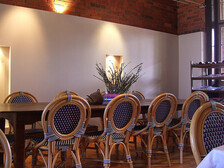

In [22]:
r = docs.find_one()
print(r['captions'])
r['img']

In [ ]:
from architectures.embeddings import AverageOfGloves
m = AverageOfGloves()
job_id = docs.create_model('average_glove', m, converter='float_tensor', loader_kwargs={'batch_size': 100},
                           key='captions', verbose=False)

In [ ]:
docs.watch_job(job_id)

In [ ]:
import numpy
from matplotlib import pyplot as plt

n = len(docs['_semantic_indexes'].find_one({"name": 'text2image_search'})['weights'].keys())
plt.figure(figsize=(8, n * 6), dpi=80)
for i, k in enumerate(docs['_semantic_indexes'].find_one({"name": 'text2image_search'})['weights']):
    w = docs['_semantic_indexes'].find_one({"name": 'text2image_search'})['weights'][k]
    plt.subplot(n, 1, i + 1)
    plt.title(k)
    plt.plot(w)
    
plt.show()

In [ ]:
docs.delete_losses(['ranking_loss'], force=True)
docs.delete_metrics(['p_at_1', 'p_at_10'], force=True)
docs.delete_semantic_index('text2image_search', force=True)
docs.delete_measures(['css'], force=True)

In [ ]:
from architectures.metrics import PatK
from architectures.losses import ranking_loss
from architectures.measures import dot, css
import torch


docs.create_semantic_index(
    'text2image_search',
    models=[
        {
            'name': 'image_encoder', 
            'object': torch.nn.Linear(2048, 50),
            'features': {'image': 'resnet'},
            'key': 'image',
            'converter': 'float_tensor',
            'active': True,
        },
        {
            'name': 'text_encoder', 
            'object': torch.nn.Identity(),
            'features': {'captions': 'average_glove'},
            'key': 'captions',
            'converter': 'float_tensor',
            'active': False,
        },
    ],
    loss={
        'name': 'ranking_loss',
        'object': ranking_loss,
    },
    filter={},
    projection={'image': 0, '_like': 0},
    metrics=[
        {
            'name': 'p_at_1', 
            'object': PatK(1),
        },
        {
            'name': 'p_at_10', 
            'object': PatK(10),
        }
    ],
    measure={'name': 'css', 'object': css},
    features={'captions': 'average_glove', 'image': 'resnet'},
    batch_size=250,
    num_workers=0,
    n_epochs=3,
    lr=0.001,
    log_weights=True,
    download=True,
    validation_interval=50,
    no_improve_then_stop=5,
    n_iterations=1000,
)

In [ ]:
docs.semantic_index = 'text2image_search'

In [ ]:
query = 'a store selling fruits and vegetables'
for r in docs.find({'$like': {'document': {'captions': [query]}, 'n': 10}}).limit(5):
    display(r['image'])